# Portafolio óptimo que maximiza el índice de Sharpe

Mariana Carmona

In [89]:
import numpy as np
import pandas as pd
import pandas_datareader.data as wb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from datetime import datetime
import yfinance as yf
import seaborn as sns
from scipy.stats import norm

In [90]:
activos = ['IBM', 'AMZN', 'AAPL']

In [91]:
#df = pd.read_csv("precios.csv")
#activos = ['MCD', 'WMT', 'KO', 'T', 'BAC', 'KHC', 'BA', 'TSLA', 'AMZN', 'AAPL',
#       'VZ', 'PFE', 'GS', 'MMM', 'AXP', 'CAT', 'FCAU', 'UL', 'COST', 'XOM']
#df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace = True)

In [92]:
# Definir el rango de fechas
fecha_inicio = '2015-12-01'
fecha_fin = '2020-11-30'

# Crear DataFrame vacío para almacenar los precios mensuales
df = pd.DataFrame()

# Descargar precios mensuales para cada activo
for t in activos:
    # Utilizar 'yf.download' para obtener los precios de Yahoo Finance
    data = yf.download(t, start=fecha_inicio, end=fecha_fin)
    
    # Agregar la columna al DataFrame 'df' con el nombre del activo
    df[t] = data['Adj Close'].resample('MS').first()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [93]:
df.head()

,IBM,AMZN,AAPL
Date,,,
2015-12-01,94.957680,33.952999,26.741558
2016-01-01,91.375244,31.849501,24.009069
2016-02-01,83.901230,28.740499,21.976210
2016-03-01,91.235794,28.952000,23.034914
2016-04-01,103.559464,29.924999,25.202526


## Optimización algorítmica (Markowitz)

In [94]:
# Calcular los cambios porcentuales en todas las columnas numéricas
retornos_log = np.log(1+df.pct_change())
# Si deseas mantener solo los cambios porcentuales y eliminar la primera fila (que contiene NaN)
retornos_log = retornos_log.dropna()
retornos_log.head()

,IBM,AMZN,AAPL
Date,,,
2016-01-01,-0.038457,-0.063955,-0.107787
2016-02-01,-0.085334,-0.102714,-0.088471
2016-03-01,0.083807,0.007332,0.047051
2016-04-01,0.126699,0.033055,0.089933
2016-05-01,-0.048702,0.133312,-0.160932


In [95]:
matriz_cov = retornos_log.cov()

In [96]:
matriz_cov.head()

,IBM,AMZN,AAPL
IBM,0.005822,0.002772,0.003409
AMZN,0.002772,0.006022,0.004257
AAPL,0.003409,0.004257,0.009093


Se define una función estadisticos_portafolio que toma un conjunto de pesos y los retornos logarítmicos de los activos, y devuelve un diccionario con los retornos esperados, la volatilidad y el índice de Sharpe del portafolio.

Al multiplicar las matrices por 12 para ajustar los cálculos a una base anual, se están calculando los pesos que maximizan la cartera en un plazo de un año. El resultado de la optimización se expresará en términos anuales, lo que significa que representa el rendimiento y la volatilidad de la cartera en un horizonte de tiempo de un año.


Al realizar la optimización, se están buscando los pesos óptimos para los activos en la cartera que maximicen el índice de Sharpe anualizado. El índice de Sharpe anualizado es una medida de la rentabilidad ajustada al riesgo anualizada, lo que te permite comparar diferentes estrategias de inversión en un horizonte de tiempo de un año.


Es importante tener en cuenta que al utilizar datos históricos para estimar los rendimientos y la volatilidad de los activos, se está asumiendo que las características pasadas de los activos reflejarán su comportamiento futuro. Sin embargo, los mercados financieros son dinámicos y pueden cambiar, por lo que los resultados obtenidos a través de la optimización basada en datos históricos pueden no garantizar un rendimiento similar en el futuro.

In [97]:
# Función que empaqueta la volatilidad, los retornos y el ratio sharpe
def estadisticos_portafolio(pesos, retornos_log, matriz_cov):
    #Se calculan los retornos anuales esperados para cada portafolio utilizando: 
    port_retornos = np.sum(pesos*retornos_log.mean())*12 
    # Se calcula la volatilidad anual de cada portafolio utilizando:
    port_vols = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*12,pesos)))
    sharpe = port_retornos / port_vols
    return {'Retornos': port_retornos, 'Volatilidad': port_vols, 'Sharpe': sharpe}

El objetivo ahora es encontrar el conjunto de pesos que maximiza el índice de Sharpe. Para ello, se define una función `minimize_sharpe` que simplemente devuelve el negativo del índice de Sharpe. Esto se debe a que las funciones de optimización en SciPy están diseñadas para minimizar una función, y queremos maximizar el índice de Sharpe.

Se establecen los límites para los pesos (entre 0 y 1) y la restricción de que la suma de los pesos debe ser igual a 1. Luego se utiliza la función `optimize.minimize` para encontrar el conjunto de pesos que minimiza la función `minimize_sharpe` (maximiza el índice de Sharpe).

In [98]:
def minimize_sharpe (pesos, retornos_log, matriz_cov):
    return -estadisticos_portafolio(pesos, retornos_log, matriz_cov)['Sharpe']

El resultado de esta optimización es el conjunto de pesos que maximiza el índice de Sharpe para el portafolio, dado los datos históricos proporcionados y bajo la restricción de que la suma de los pesos es igual a 1. Esto proporciona una guía de cómo un inversor podría querer distribuir su capital entre los diferentes activos para lograr el mejor retorno ajustado al riesgo.

In [99]:
# Condiciones y restricciones para minimizar el Sharpe Ratio con optimize.minimize
inicializador = num_activos * [1./num_activos]
bounds = tuple((0,1) for x in range(num_activos))

# Se agrega la restricción de que la suma de los pesos sea igual a 1
suma_pesos_restriccion = {'type': 'eq', 'fun': lambda pesos: np.sum(pesos) - 1}

# Lista de restricciones, que en este caso es solo la suma de los pesos
restricciones = [suma_pesos_restriccion]

Se utiliza un algoritmo de optimización (SLSQP) para encontrar la cartera que maximiza el ratio de Sharpe, sujeta a la restricción de que la suma de los pesos de los activos sea igual a 1.

* `minimize_sharpe`: Función objetivo que retorna el negativo del ratio de Sharpe. Se usa el negativo porque el algoritmo de optimización minimiza la función objetivo, y queremos maximizar el ratio de Sharpe.

* `estadisticos_portafolio`: Función que calcula los retornos, la volatilidad y el ratio de Sharpe de una cartera dada.
* `inicializador`: Punto de inicio para el algoritmo de optimización, en este caso, igual ponderación para todos los activos.
* `bounds`: Límites para los pesos de los activos. En este caso, todos los pesos deben estar entre 0 y 1.
* `suma_pesos_restriccion`: Restricción para que la suma de los pesos sea igual a 1.
* `sharpe_optimo`: Resultado de la optimización. Contiene los pesos óptimos de la cartera que maximiza el ratio de Sharpe.
* `sharpe_optimo_pesos`: Pesos óptimos redondeados.
* `estadisticos_optimos`: Estadísticas (retornos, volatilidad y ratio de Sharpe) de la cartera óptima.

In [100]:
# Encontrar el portafolio óptimo que maximiza el índice de Sharpe con la restricción de la suma de pesos igual a 1
sharpe_optimo = optimize.minimize(minimize_sharpe, inicializador, method = 'SLSQP', args=(retornos_log, matriz_cov), bounds=bounds, constraints=restricciones)
sharpe_optimo_pesos = sharpe_optimo['x'].round(3)
estadisticos_optimos = estadisticos_portafolio(sharpe_optimo_pesos, retornos_log, matriz_cov)

In [101]:
sharpe_optimo_pesos

array([0.   , 0.792, 0.208])

In [102]:
print('Pesos óptimos de la cartera: ', list(zip(activos, list(sharpe_optimo_pesos*100))))
print('Retorno óptimo de la cartera: ', np.round(estadisticos_optimos['Retornos']*100,3))
print('Volatilidad óptima de la cartera: ', np.round(estadisticos_optimos['Volatilidad']*100,3))
print('Sharpe óptimo de la cartera: ', np.round(estadisticos_optimos['Sharpe'],3))

Pesos óptimos de la cartera:  [('IBM', 0.0), ('AMZN', 79.2), ('AAPL', 20.8)]
Retorno óptimo de la cartera:  29.815
Volatilidad óptima de la cartera:  25.861
Sharpe óptimo de la cartera:  1.153


Se utiliza el índice de Sharpe para identificar el portafolio que ofrece el mejor retorno ajustado al riesgo. Se guarda la volatilidad y los retornos del portafolio con el mayor índice de Sharpe.

Para la gráfica, se generan 100,000 portafolios con pesos aleatorios asignados a cada activo. Para cada portafolio, se calculan los retornos esperados y la volatilidad.

In [103]:
port_retornos = []
port_vols = []

for i in range(1000):
    num_activos = len(retornos_log.columns)
    pesos = np.random.random(num_activos)
    pesos /= np.sum(pesos)
    port_retornos.append(np.sum(pesos*retornos_log.mean())*12)
    port_vols.append(np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*12,pesos))))

port_retornos = np.array(port_retornos)
port_vols = np.array(port_vols)

In [104]:
sharpe = port_retornos / port_vols
max_sr_retornos = port_retornos[sharpe.argmax()]
max_sr_volatilidad = port_vols[sharpe.argmax()]

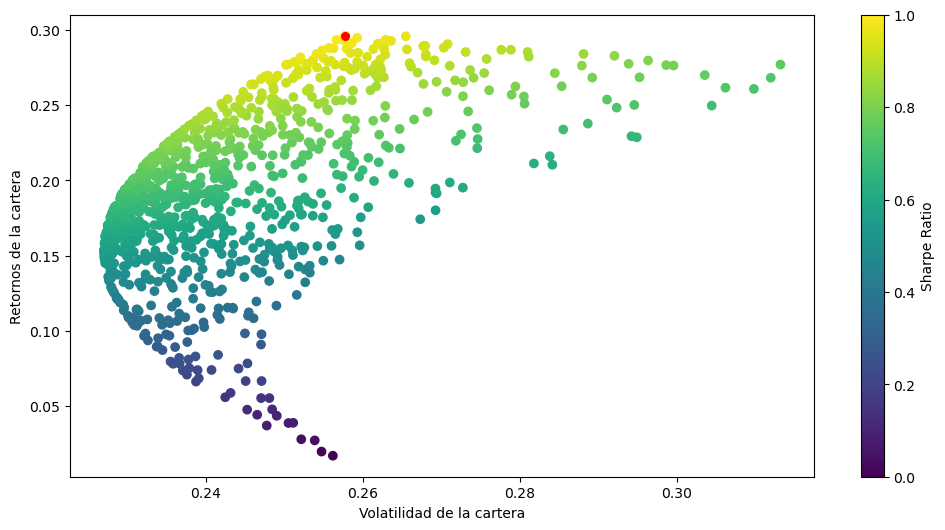

In [105]:
plt.figure(figsize=(12,6))
plt.scatter(port_vols, port_retornos, c = (port_retornos / port_vols))
plt.scatter(max_sr_volatilidad, max_sr_retornos, c='red', s=30)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatilidad de la cartera')
plt.ylabel('Retornos de la cartera')
plt.show()